![Image of Yaktocat](https://seeders.nl/wp-content/uploads/2020/03/seeders-logo.png)
# SERP Analyser
*This notebook gets SERPs for top searched keywords in Europe and anlayses the top 10 results to gain insights for important SEO ranking factors across Europe.*

### We will analyse SERPS based on the following questions<br>
 - Is the domain exstension a ranking factor?<br>
 - ??

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from df2gspread import df2gspread as d2g
from gspread_pandas import Spread, Client 
from oauth2client.service_account import ServiceAccountCredentials

import requests as rq
from requests import get
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import urllib
from urllib.parse import urlparse

import matplotlib.pyplot as plt 
import seaborn as sns

### Get the data from google spreadsheets

In [2]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('C:/Users/Anne/PycharmProjects/crawlersAndscrapers/Scrapers and Crawlers-79156bc3792f.json', scope)
# credentials = ServiceAccountCredentials.from_json_keyfile_name('C:/Users/TJAwi/OneDrive/Bureaublad/githubSyncer/scrapers-and-crawlers-3e70bf97958c.json', scope)
client = gspread.authorize(credentials)
print("Authorizing.......")

spreadsheet_key = '1n6lCJTKjX6ZDlP8WSv_6ZNgq11SwFM_Owbkfo_hmCwo'
print("Opening.......")
sheet = client.open("Zoekwoorden voor onderzoek").sheet1

Authorizing.......
Opening.......


### Clean the data

In [3]:
df = get_as_dataframe(sheet, header=[0,1])#GET ONLY ROWS POPULATED WITH DATA
df = df[0:21]
df = df.filter(regex='^((?!Unnamed).)*$', axis=1) #REMOVE ALL COLUMNS WHERE THE HEADER IS UNNAMED
df = df.filter(regex='^((?!Volume).)*$', axis=1) #REMOVE ALL COLUMNS CONTAINING VAGUE SEARCH VOLUME DATA
df = df.rename(columns=lambda x: x.strip()) #REMOVE WHITESPACE FROM COLUMN NAMES
df.head(3)

,Nederland,Duitsland,Engeland,Spanje,Italie,Frankrijk,Portugal,Belgie,Denemarken,Zweden,Polen
,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword,Keyword
0,autoverzekering,Autoversicherung,Car insurance,seguro coche,assicurazione auto,assurance auto,seguro automóvel,autoverzekering,bilforsikring,bilförsäkring,ubezpieczenie samochodu
1,sneakers,Sneakers,Sneakers,Sneakers,scarpe da ginnastica,sneakers,ténis,sneakers,sneakers,sneakers,sneakers
2,geld lenen,Geld leihen,Money loan,prestar dinero,prestiti,prêt,empréstimo,geld lenen,låne penge,låna pengar,pożyczka gotówkowa


## Build Google Search function

Use Google Search API via RapidAPI, untill 600 calls per month. Should be oke with 220 calls (220 kw's)<br>

---

In [4]:
headers = {
    "x-rapidapi-key": "d002f154d0msh2d0fced5ee6898cp1dc73cjsn24c405fb0353",
    "x-rapidapi-host" :"google-search3.p.rapidapi.com"
}

def search(keyword, gl):
    
    query = {
        "q": keyword,
        "gl": gl
    }
    
    resp = rq.get("https://rapidapi.p.rapidapi.com/api/v1/search/" + urllib.parse.urlencode(query), headers=headers)
    results = resp.json()
    return results['results']

## Fetch top 10 results for each keyword

In [5]:
# urls = [] #create list of lists so we can we have a list on the side 
# for column in df:
#     column_urls = [] #create list of lists so we can convert this list to the subcolumn 'urls'
#     keywords = df[column] #list of keywords per country
    
#     for keyword in keywords:
        
#         if 'Nederland' in column[0]:
#             gl = 'NL'
            
#         elif 'Duitsland' in column[0]:
#             gl = 'DE'
            
#         elif 'Engeland' in column[0]:
#             gl = 'UK'
            
#         elif 'Spanje' in column[0]:
#             gl = 'ES'
            
#         elif 'Italie' in column[0]:
#             gl = 'IT'
            
#         elif 'Frankrijk' in column[0]:
#             gl = 'FR'
            
#         elif 'Portugal' in column[0]:
#             gl = 'PT'
            
#         elif 'Belgie' in column[0]:
#             gl = 'BE'
            
#         elif 'Denemarken' in column[0]:
#             gl = 'DK'
            
#         elif 'Zweden' in column[0]:
#             gl = 'SE'
            
#         elif 'Polen' in column[0]:
#             gl = 'PL'
            
#         temp = [] #create temporary list so results are put in a list of lists
#         print("Current KW:    ", keyword)
#         for result in search(keyword, gl):  #str(column[0])
#             temp.append(result['link'])
#         column_urls.append(temp)
        
#         df[str(column[0]),'urls'] = pd.Series(column_urls)# update dataframe with subcolumn 'urls'
#         df = df.sort_index(axis=1) #convert back to dataframe
#     urls.append(column_urls)

# df

## Save DF to spreadsheet for later use

In [6]:
spread = Spread("Zoekwoorden voor onderzoek")
# print("Uploading.......")
# spread.df_to_sheet(df, index=False, sheet='updated with serps')
# print("Done!")

## Get saved DF from spreadsheet

In [7]:
#Get spreadsheet from here and convert to df again
#Maybe try to progamatically find and fill the empty cells
SERPdf = spread.sheet_to_df(index=0, header_rows=2, sheet='updated with serps')
SERPdf.head(5)

Belgie                                                     \
               Keyword                                               urls   
0      autoverzekering  ['https://www.verzekeringen.be/autoverzekering...   
1             sneakers  ['https://www.sneakersstores.be/', 'https://ww...   
2           geld lenen  ['https://www.geldlenen.be/', 'https://www.bel...   
3       eten bestellen  ['https://www.takeaway.com/be/Online-eten-best...   
4  hypothecaire lening  ['https://www.kbc.be/particulieren/nl/product/...   

        Denemarken                                                     \
           Keyword                                               urls   
0    bilforsikring  ['https://www.if.dk/privat/forsikringer/bilfor...   
1         sneakers  ['https://rezetstore.dk/sneakers', 'https://re...   
2       låne penge  ['https://ikanobank.dk/laan', 'https://www.mik...   
3  mad ud af huset  ['https://gaudium.dk/mad-ud-af-huset/', 'https...   
4    realkreditlån  ['https://www.totalkredit.dk/boliglan/kob-af-b...   

          Duitsland                                                     \
            Keyword                                               urls   
0  Autoversicherung  ['https://www.huk.de/fahrzeuge/kfz-versicherun...   
1          Sneakers  ['https://www.zalando.de/damenschuhe-sneaker/'...   
2       Geld leihen  ['https://www.smava.de/privatkredit/geld-leihe...   
3   Essen bestellen  ['https://www.lieferando.de/essen-bestellen-be...   
4          Hypothek  ['https://de.wikipedia.org/wiki/Hypothek#:~:te...   

        Engeland                                                     \
         Keyword                                               urls   
0  Car insurance  ['https://www.moneysupermarket.com/car-insuran...   
1       Sneakers  ['https://www.sneakersnstuff.com/en', 'https:/...   
2     Money loan  ['https://www.moneysupermarket.com/loans/', 'h...   
3     Order food  ['https://foodhub.co.uk/', 'https://www.uberea...   
4       Mortage   ['https://www.thefreedictionary.com/Mortage', ...   

            Frankrijk                                                     ...  \
              Keyword                                               urls  ...   
0      assurance auto  ['https://www.maaf.fr/fr/assurance-auto', 'htt...  ...   
1            sneakers  ['https://www.sneakers.fr/', 'https://www.cour...  ...   
2                prêt  ['https://www.linternaute.fr/dictionnaire/fr/d...  ...   
3  commander à manger  ['https://www.01net.com/astuces/5-applications...  ...   
4             emprunt  ['https://www.meilleurtaux.com/credit-immobili...  ...   

         Nederland                                                     \
           Keyword                                               urls   
0  autoverzekering  ['https://www.independer.nl/autoverzekering/in...   
1         sneakers  ['https://www.sneakers.nl/', 'https://www.zala...   
2       geld lenen  ['https://www.pricewise.nl/geld-lenen/', 'http...   
3   eten bestellen  ['https://www.thuisbezorgd.nl/eten-bestellen',...   
4        hypotheek  ['https://www.abnamro.nl/nl/prive/hypotheken/m...   

                     Polen                                                     \
                   Keyword                                               urls   
0  ubezpieczenie samochodu  ['https://www.link4.pl/ubezpieczenie-samochodu...   
1                 sneakers  ['https://www.sneakers.pl/', 'https://www.snea...   
2       pożyczka gotówkowa  ['https://www.totalmoney.pl/kredyty_gotowkowe'...   
3            zamów posiłek  ['http://zamowposilek.pl/', 'https://play.goog...   
4        kredyt hipoteczny  ['https://www.totalmoney.pl/kredyty_hipoteczne...   

              Portugal                                                     \
               Keyword                                               urls   
0     seguro automóvel  ['https://www.fidelidade.pt/PT/particulares/Au...   
1                ténis  ['https://pt.wikipedia.org/wiki/T%C3%A9nis',

## Add column with the domains

In [8]:
import ast #needed for string to list conversion

for column in SERPdf:
    domains = []
    for urls in SERPdf[str(column[0]),'urls']:
        urls = ast.literal_eval(urls) #convert string back to list of lists
        temp = []
        for url in urls:
#             print(url)
            parsed = urlparse(url)
            domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed)
#             print(domain)
            temp.append(domain)
        domains.append(temp)
    SERPdf[str(column[0]),'domains'] = pd.Series(domains)
    
SERPdf = SERPdf.sort_index(axis=1)
SERPdf.head(5)

Belgie                                                     \
               Keyword                                            domains   
0      autoverzekering  [https://www.verzekeringen.be/, https://www.in...   
1             sneakers  [https://www.sneakersstores.be/, https://www.z...   
2           geld lenen  [https://www.geldlenen.be/, https://www.belfiu...   
3       eten bestellen  [https://www.takeaway.com/, https://www.takeaw...   
4  hypothecaire lening  [https://www.kbc.be/, http://www.axabank.be/, ...   

                                                           Denemarken  \
                                                urls          Keyword   
0  ['https://www.verzekeringen.be/autoverzekering...    bilforsikring   
1  ['https://www.sneakersstores.be/', 'https://ww...         sneakers   
2  ['https://www.geldlenen.be/', 'https://www.bel...       låne penge   
3  ['https://www.takeaway.com/be/Online-eten-best...  mad ud af huset   
4  ['https://www.kbc.be/particulieren/nl/product/...    realkreditlån   

                                                      \
                                             domains   
0  [https://www.if.dk/, https://www.alka.dk/, htt...   
1  [https://rezetstore.dk/, https://rezetstore.dk...   
2  [https://ikanobank.dk/, https://www.mikonomi.d...   
3  [https://gaudium.dk/, https://www.foetexudafhu...   
4  [https://www.totalkredit.dk/, https://www.rd.d...   

                                                             Duitsland  \
                                                urls           Keyword   
0  ['https://www.if.dk/privat/forsikringer/bilfor...  Autoversicherung   
1  ['https://rezetstore.dk/sneakers', 'https://re...          Sneakers   
2  ['https://ikanobank.dk/laan', 'https://www.mik...       Geld leihen   
3  ['https://gaudium.dk/mad-ud-af-huset/', 'https...   Essen bestellen   
4  ['https://www.totalkredit.dk/boliglan/kob-af-b...          Hypothek   

                                                      \
                                             domains   
0  [https://www.huk.de/, https://www.adac.de/, ht...   
1  [https://www.zalando.de/, https://www.snipes.c...   
2  [https://www.smava.de/, https://www.vergleich....   
3  [https://www.lieferando.de/, https://www.liefe...   
4  [https://de.wikipedia.org/, https://de.wikiped...   

                                                           Engeland  ...  \
                                                urls        Keyword  ...   
0  ['https://www.huk.de/fahrzeuge/kfz-versicherun...  Car insurance  ...   
1  ['https://www.zalando.de/damenschuhe-sneaker/'...       Sneakers  ...   
2  ['https://www.smava.de/privatkredit/geld-leihe...     Money loan  ...   
3  ['https://www.lieferando.de/essen-bestellen-be...     Order food  ...   
4  ['https://de.wikipedia.org/wiki/Hypothek#:~:te...       Mortage   ...   

                                               Polen             Portugal  \
                                                urls              Keyword   
0  ['https://www.link4.pl/ubezpieczenie-samochodu...     seguro automóvel   
1  ['https://www.sneakers.pl/', 'https://www.snea...                ténis   
2  ['https://www.totalmoney.pl/kredyty_gotowkowe'...           empréstimo   
3  ['http://zamowposilek.pl/', 'https://play.goog...  comida ao domicilio   
4  ['https://www.totalmoney.pl/kredyty_hipoteczne...             hipoteca   

                                                      \
                                             domains   
0  [https://www.fidelidade.pt/, https://www.deco....   
1  [https://pt.wikipedia.org/, https://www.tenis....   
2  [https://www.bancoctt.pt/, https://www.cetelem...   
3  [https://www.nomenu.pt/, https://www.takeaway....   
4  [https://www.advogadosinsolvencia.pt/, https:/...   

                                                      \
                                                urls   
0  ['https://www.fidelidade.pt/PT/particulares/Au...   
1  ['https://pt.wikipedia

## Add column with the Top Level Domains (TLDs)

In [9]:
#Get tld's
for column in SERPdf:    
    tlds = []
    for domainlist in SERPdf[str(column[0]),'domains']:
#         print(domainlist)
        temp = []
        for domain in domainlist:
            tld = domain.rpartition('.')[2]  
            temp.append(tld)
        tlds.append(temp)
    SERPdf[str(column[0]), 'tlds'] = pd.Series(tlds)

SERPdf = SERPdf.sort_index(axis=1)
SERPdf.head(2)

Belgie                                                     \
           Keyword                                            domains   
0  autoverzekering  [https://www.verzekeringen.be/, https://www.in...   
1         sneakers  [https://www.sneakersstores.be/, https://www.z...   

                                                  \
                                            tlds   
0  [be/, be/, be/, be/, be/, be/, be/, be/, be/]   
1  [be/, be/, be/, be/, nl/, be/, be/, nl/, be/]   

                                                         Denemarken  \
                                                urls        Keyword   
0  ['https://www.verzekeringen.be/autoverzekering...  bilforsikring   
1  ['https://www.sneakersstores.be/', 'https://ww...       sneakers   

                                                      \
                                             domains   
0  [https://www.if.dk/, https://www.alka.dk/, htt...   
1  [https://rezetstore.dk/, https://rezetstore.dk...   

                                                      \
                                                tlds   
0  [dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, ...   
1  [dk/, dk/, dk/, dk/, dk/, com/, dk/, dk/, dk/,...   

                                                             Duitsland  \
                                                urls           Keyword   
0  ['https://www.if.dk/privat/forsikringer/bilfor...  Autoversicherung   
1  ['https://rezetstore.dk/sneakers', 'https://re...          Sneakers   

                                                      ...  \
                                             domains  ...   
0  [https://www.huk.de/, https://www.adac.de/, ht...  ...   
1  [https://www.zalando.de/, https://www.snipes.c...  ...   

                                            Portugal  \
                                                tlds   
0  [pt/, pt/, pt/, pt/, pt/, pt/, pt/, pt/, pt/, ...   
1   [org/, pt/, pt/, pt/, pt/, com/, com/, pt/, pt/]   

                                                            Spanje  \
                                                urls       Keyword   
0  ['https://www.fidelidade.pt/PT/particulares/Au...  seguro coche   
1  ['https://pt.wikipedia.org/wiki/T%C3%A9nis', '...      Sneakers   

                                                      \
                                             domains   
0  [https://www.rastreator.com/, https://www.mutu...   
1  [https://www.snipes.es/, https://www.jdsports....   

                                                      \
                                                tlds   
0  [com/, es/, com/, com/, es/, es/, es/, es/, com/]   
1  [es/, es/, com/, com/, es/, es/, com/, com/, c...   

                                                             Zweden  \
                                                urls        Keyword   
0  ['https://www.rastreator.com/seguros-de-coche....  bilförsäkring   
1  ['https://www.snipes.es/c/shoes/sneaker', 'htt...       sneakers   

                                                      \
                                             domains   
0  [https://www.lansforsakringar.se/, https://www...   
1  [https://www.sneakerspoint.se/, https://www.za...   

                                                      \
                                                tlds   
0  [se/, se/, se/, se/, se/, se/, se/, se/, se/, ...   
1  [se/, se/, se/, se/, com/, com/, se/, com/, se...   

                                                      
                                                urls  
0  ['https://www.lansforsakringar.se/privat/forsa...  
1  ['https://www.sneakerspoint.se/', 'https://www...  

[2 rows x 44 columns]

## Identify native tlds
*We need to tell the program when a tld is native, which will make our analysis easier*

In [10]:
natives_test = []
for column in SERPdf:
    for tldlist in SERPdf[str(column[0]),'tlds']:
        for tld in tldlist[:1]: 
            natives_test.append(tld)
natives_test = set(natives_test)            
print(len(natives_test))
print(natives_test)

16
{'it/', 'pt/', 'de/', 'org/', 'nl/', 'pl/', 'net/', 'be/', 'br/', 'uk/', 'fr/', 'se/', 'dk/', 'com/', 'eu/', 'es/'}


In [11]:
natives = {'pl/', 'uk/', 'fr/', 'es/', 'dk/', 'it/', 'se/', 'de/', 'pt/','nl/', 'be/'}
print(len(natives))

11


## Analyse TLDs among all countries
*Countries we analysed:*
 - Netherlands
 - Germany
 - Belgium
 - Portugal
 - Italy
 - France
 - Spain
 - Sweden
 - Polen
 - United Kingdom
 - Denmark

In [12]:
all_tlds = []
for column in SERPdf:
    for tldlist in SERPdf[str(column[0]), 'tlds']:
        for tld in tldlist:
            all_tlds.append(tld)

# print(all_tlds)

In [13]:
non_natives = []
for tld in all_tlds:
    if tld not in natives:
        non_natives.append(tld)
non_natives = set(non_natives)

<br>
*As in turns out, the 'non-native' tlds are not necessarily global tlds. Some are regional, are from another country, but with the same language!*
<br>
<br>

In [14]:
for tld in non_natives:
    print(tld)

org/
vlaanderen/
br/
net/
info/
ca/
ch/
gov/
nu/
at/
co/
online/
car/
io/
la/
com/
mx/
eu/


In [15]:
use_of_native = sum(1 for tld in all_tlds if tld in natives)
use_of_non_native = sum(1 for tld in all_tlds if tld in non_natives)
print(use_of_native)
print(use_of_non_native)

5888
2632


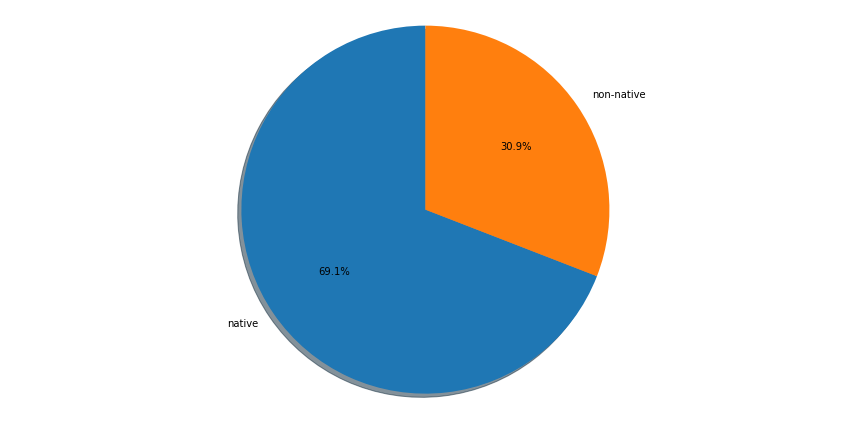

In [16]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'native', 'non-native'
sizes = [use_of_native, use_of_non_native]

fig1, ax1 = plt.subplots(figsize=(15, 7.5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [17]:
for column in SERPdf:
    print(column[0])

Belgie
Belgie
Belgie
Belgie
Denemarken
Denemarken
Denemarken
Denemarken
Duitsland
Duitsland
Duitsland
Duitsland
Engeland
Engeland
Engeland
Engeland
Frankrijk
Frankrijk
Frankrijk
Frankrijk
Italie
Italie
Italie
Italie
Nederland
Nederland
Nederland
Nederland
Polen
Polen
Polen
Polen
Portugal
Portugal
Portugal
Portugal
Spanje
Spanje
Spanje
Spanje
Zweden
Zweden
Zweden
Zweden


In [18]:
SERPdf.shape

(21, 44)

In [19]:
SERPdf.head(3)

Belgie                                                     \
           Keyword                                            domains   
0  autoverzekering  [https://www.verzekeringen.be/, https://www.in...   
1         sneakers  [https://www.sneakersstores.be/, https://www.z...   
2       geld lenen  [https://www.geldlenen.be/, https://www.belfiu...   

                                                      \
                                                tlds   
0      [be/, be/, be/, be/, be/, be/, be/, be/, be/]   
1      [be/, be/, be/, be/, nl/, be/, be/, nl/, be/]   
2  [be/, be/, be/, be/, be/, be/, be/, com/, be/,...   

                                                         Denemarken  \
                                                urls        Keyword   
0  ['https://www.verzekeringen.be/autoverzekering...  bilforsikring   
1  ['https://www.sneakersstores.be/', 'https://ww...       sneakers   
2  ['https://www.geldlenen.be/', 'https://www.bel...     låne penge   

                                                      \
                                             domains   
0  [https://www.if.dk/, https://www.alka.dk/, htt...   
1  [https://rezetstore.dk/, https://rezetstore.dk...   
2  [https://ikanobank.dk/, https://www.mikonomi.d...   

                                                      \
                                                tlds   
0  [dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, ...   
1  [dk/, dk/, dk/, dk/, dk/, com/, dk/, dk/, dk/,...   
2  [dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, dk/, ...   

                                                             Duitsland  \
                                                urls           Keyword   
0  ['https://www.if.dk/privat/forsikringer/bilfor...  Autoversicherung   
1  ['https://rezetstore.dk/sneakers', 'https://re...          Sneakers   
2  ['https://ikanobank.dk/laan', 'https://www.mik...       Geld leihen   

                                                      ...  \
                                             domains  ...   
0  [https://www.huk.de/, https://www.adac.de/, ht...  ...   
1  [https://www.zalando.de/, https://www.snipes.c...  ...   
2  [https://www.smava.de/, https://www.vergleich....  ...   

                                            Portugal  \
                                                tlds   
0  [pt/, pt/, pt/, pt/, pt/, pt/, pt/, pt/, pt/, ...   
1   [org/, pt/, pt/, pt/, pt/, com/, com/, pt/, pt/]   
2  [pt/, pt/, org/, pt/, br/, com/, com/, pt/, br...   

                                                              Spanje  \
                                                urls         Keyword   
0  ['https://www.fidelidade.pt/PT/particulares/Au...    seguro coche   
1  ['https://pt.wikipedia.org/wiki/T%C3%A9nis', '...        Sneakers   
2  ['https://www.bancoctt.pt/o-seu-credito/credit...  prestar dinero   

                                                      \
                                             domains   
0  [https://www.rastreator.com/, https://www.mutu...   
1  [https://www.snipes.es/, https://www.jdsports....   
2  [https://www.mytriplea.com/, https://www.barym...   

                                                      \
                                                tlds   
0  [com/, es/, com/, com/, es/, es/, es/, es/, com/]   
1  [es/, es/, com/, com/, es/, es/, com/, com/, c...   
2  [com/, com/, es/, es/, es/, es/, com/, com/, c...   

                                                             Zweden  \
                                                urls        Keyword   
0  ['https://www.rastreator.com/seguros-de-coche....  bilförsäkring   
1  ['https://www.snipes.es/c/shoes/sneaker', 'htt...       sneakers   
2  ['https://www.mytriplea.com/blog/prestar-diner...    låna pengar   

                                                      \
                                             domains   
0  [https://www.lansforsakringar.se/, https://www...   
1  [https://www.sneakerspoint.se/, https:/

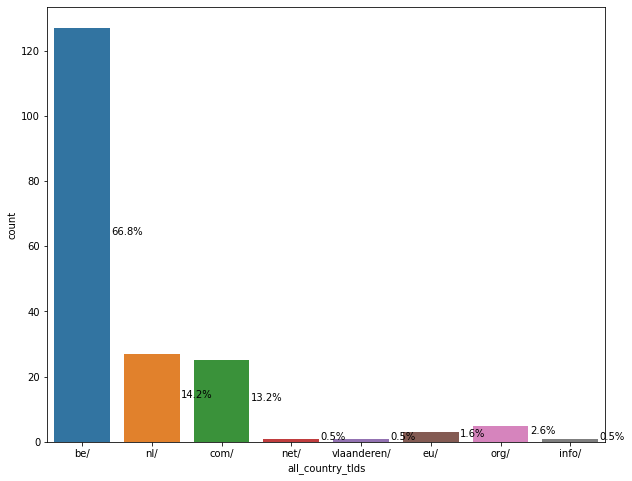

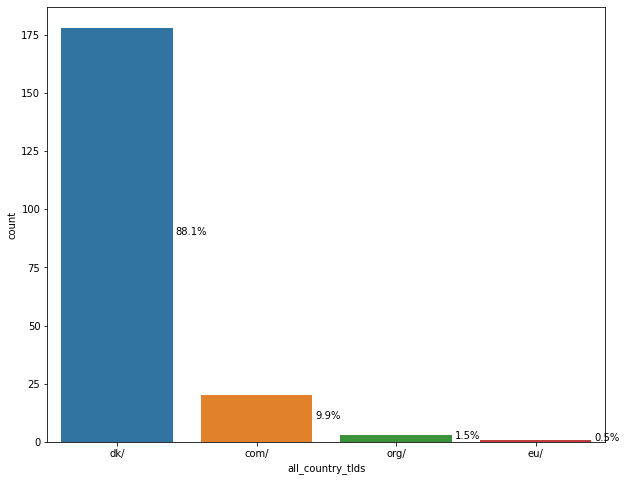

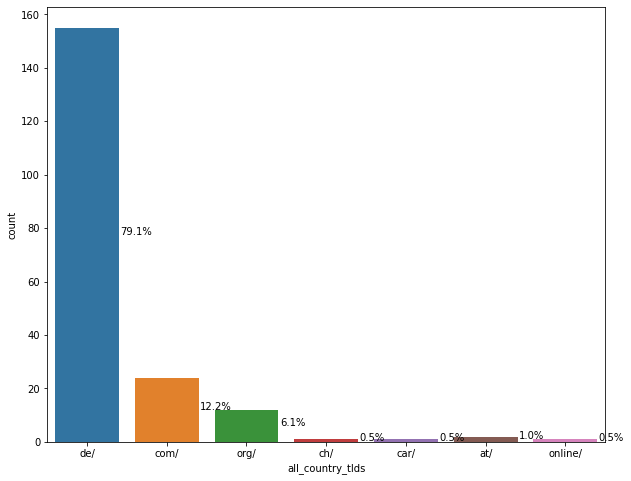

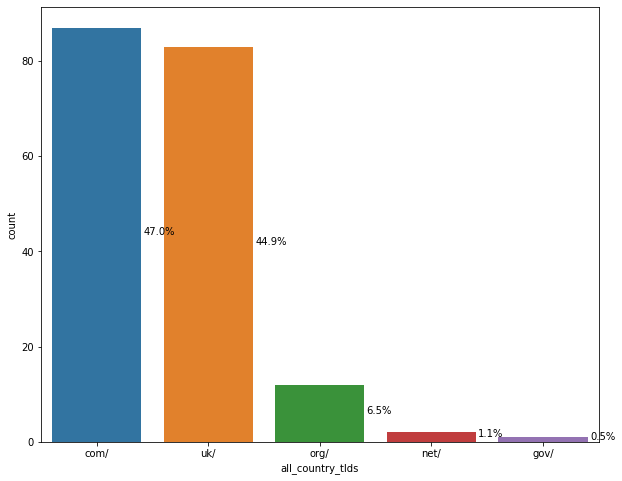

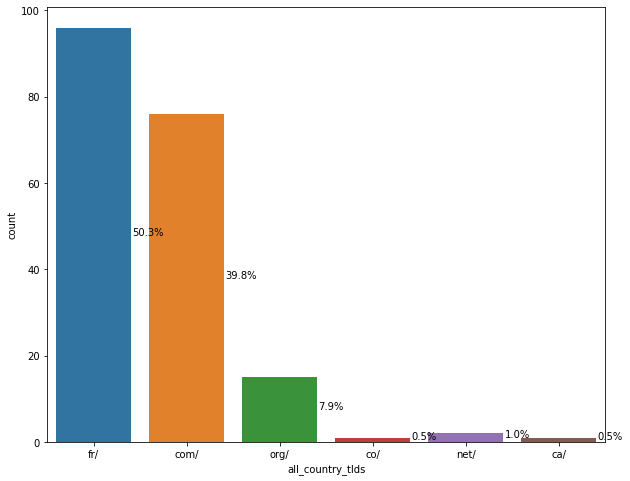

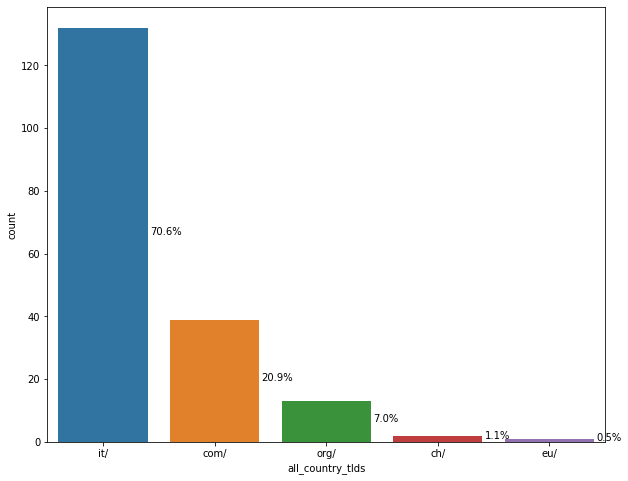

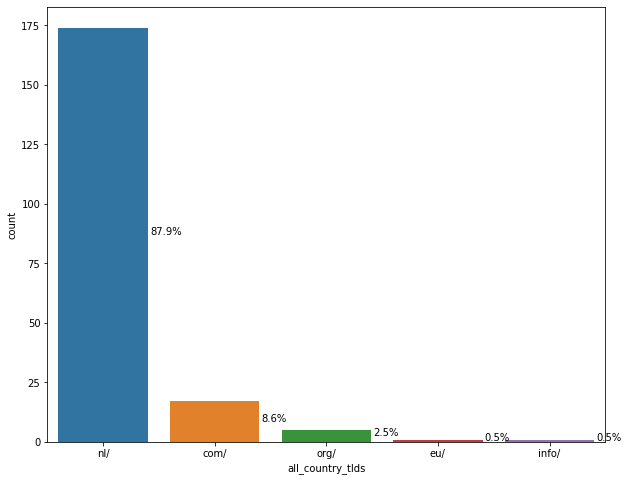

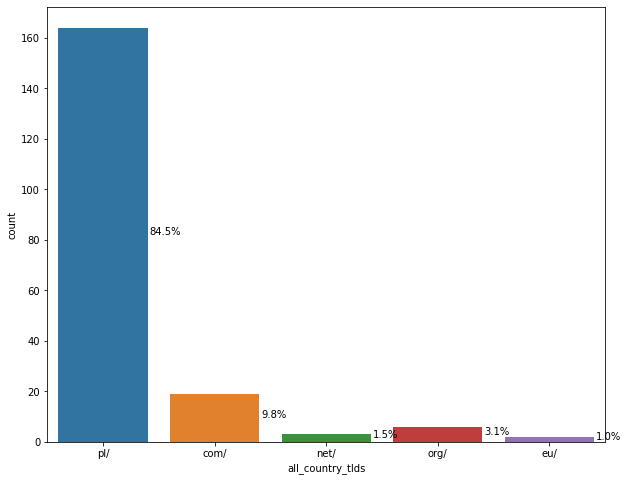

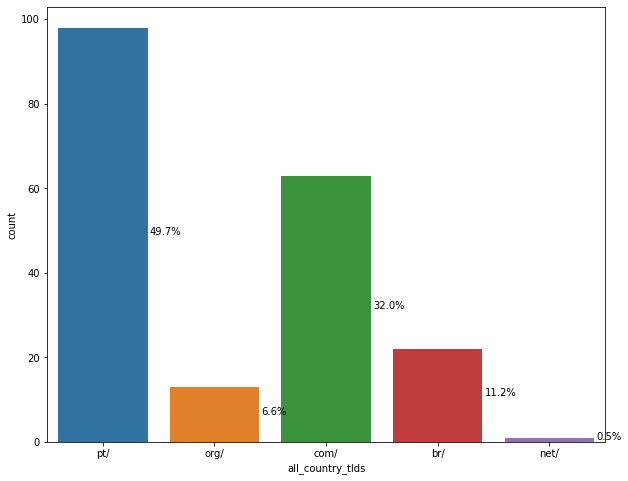

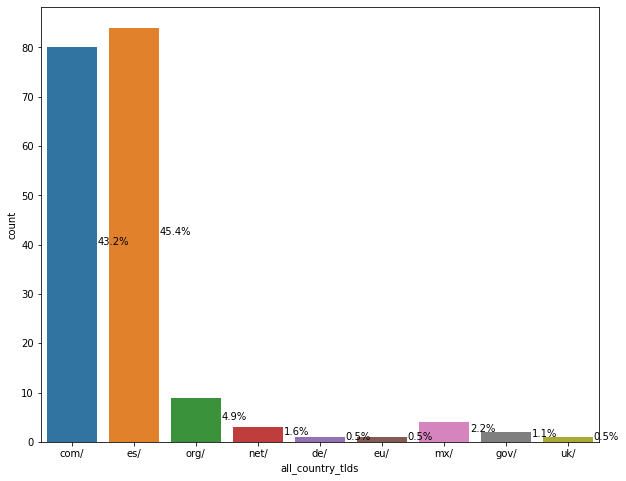

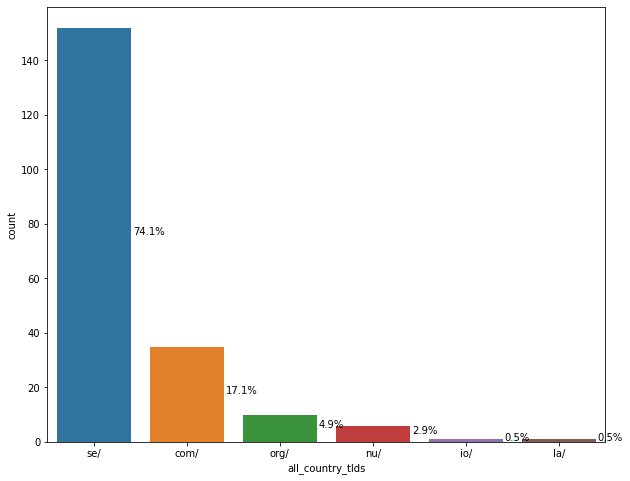

In [88]:
parsed_countries = []
for column in SERPdf:
    if str(column[0]) in parsed_countries:
        pass
    else:
        parsed_countries.append(str(column[0]))
        
        all_country_tlds = []
        for tldlists in SERPdf[str(column[0]), 'tlds']:
            for tld in tldlists:
                all_country_tlds.append(tld)

        all_country_tlds_df = pd.DataFrame(all_country_tlds, columns=['all_country_tlds'])
        plt.figure(figsize=(10,8))
        ax = sns.countplot(x='all_country_tlds', data=all_country_tlds_df)
        total = len(all_country_tlds_df['all_country_tlds'])
#         print(total)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))